### CNN for density estimation and counting

Density maps are an interesting target for CNNs.  Density maps allow you estimate dense populations without having to necessarily identify each individual in the population. My goal is to create a fully convolutional model capable of producing density maps.

A key insight that makes this approach easier than others is the way we can generate density maps from unlabeled data. While this may still be a time consuming process for extremely dense images, the labeling process only requires you to place single points on each instance of the object as opposed to bounding boxes or detailed segmentation.  

With a point map in place for a source image we can convolve a gaussian kernel with a mean of one to generate the density map. A sum over the image array will yield a count of points that is the same before and after the points map has been turned into a density map.

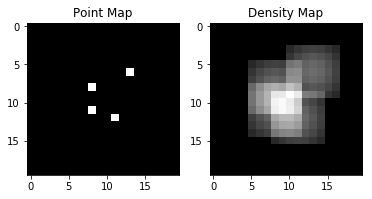

Sum of points on point map 4.0
Sum of points on density map 4.0


In [2]:
# here we will create a simple density map to illustrate the concept of turning a point map into a density map

import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# load the point map and ensure it's grayscale. at this step it's important to reduce the image to 1 channel
# so our future sum operation counts the point only once. the background is black and points are white
point_map_file = './points.png'
point_map = cv2.cvtColor(cv2.imread(point_map_file), cv2.COLOR_BGR2GRAY)

# black background doesn't change (0/255 = 0) however the white points are now 1 (255/255 = 1)
# again, important for the future sum operation
point_map = point_map / 255

# now we can convolve a gaussian kernel over the point map
density_map = cv2.GaussianBlur(point_map, (7,7), 3)

plt.subplot(121)
plt.title('Point Map')
plt.imshow(point_map, interpolation='none', cmap='gray')
plt.subplot(122)
plt.title('Density Map')
plt.imshow(density_map, interpolation='none', cmap='gray')
plt.show()

print('Sum of points on point map', point_map.sum())
print('Sum of points on density map', density_map.sum())


Great, we can demonstrate that density maps are working as expected. We can count the original sum of points even though the image has been blurred. We will create a CNN to output the same type of density map, to count crowds, or anything that has a point map!

### Augmentation for training

I'll use Keras to build the CNN and perform some of the training augmentation, but we need to do some more advanced augmentation as well!

To generate the training data we'll use an image pyramid and a sliding window, passing a window of a static size over every pyramid level, with a bit of overlap at every step. The idea here is to make the network aware of multiple zoom levels, and to generate many training examples from just one image.

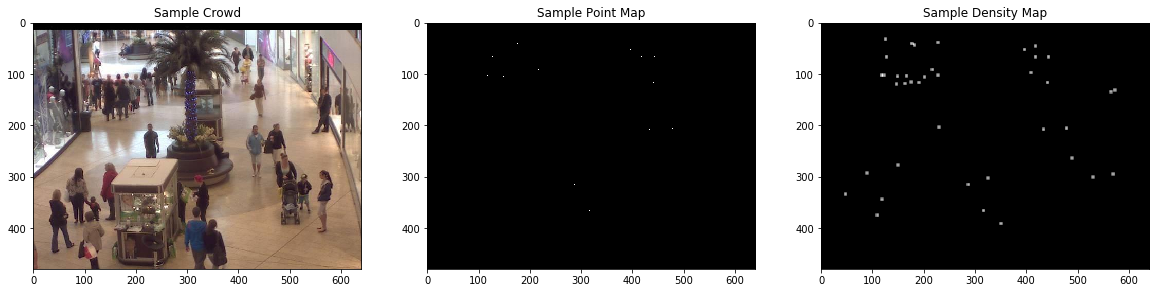

Image size (480, 640, 3)
Sum of points on point map 39.0
Sum of points on density map 39.0


In [19]:
# here's what the training images look like. in this dataset all images are from 
# this one camera and contain varying numbers of people 

# load the sample files
sample_crowd_file = './sample_crowd.jpg'
sample_crowd_point_map_file = './sample_crowd_point_map.png'
sample_crowd_img = cv2.cvtColor(cv2.imread(sample_crowd_file), cv2.COLOR_BGR2RGB)
sample_crowd_point_map_img = cv2.cvtColor(cv2.imread(sample_crowd_point_map_file), cv2.COLOR_BGR2GRAY)

# scale the point maps to zeros and ones
sample_crowd_point_map_img = sample_crowd_point_map_img / 255

# create the density map from the point map
sample_crowd_density_map_img = density_map = cv2.GaussianBlur(sample_crowd_point_map_img, (7,7), 3)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Sample Crowd')
plt.imshow(sample_crowd_img)
plt.subplot(132)
plt.title('Sample Point Map')
plt.imshow(sample_crowd_point_map_img, interpolation='none', cmap='gray')
plt.subplot(133)
plt.title('Sample Density Map')
plt.imshow(sample_crowd_density_map_img, interpolation='none', cmap='gray')

plt.show()

print('Image size', sample_crowd_img.shape)
print('Sum of points on point map', sample_crowd_point_map_img.sum())
print('Sum of points on density map', sample_crowd_density_map_img.sum())